In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)
X = t[0]
A = t[2]
y = t[3].values
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

ground = [(aa, i) for aa in aas for i in range(4)]
L = 4
n_aas = 20

seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i
wt_inds = [seq_to_x[wt]]

np.random.seed(120120)
_ = torch.manual_seed(43298)



n = 100

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
train_inds = wt_inds + single_inds + list(np.random.choice(len(X), n, replace=True))


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

inds = sorted(set(train_inds))
print(len(inds))
dic, _, mo = helpers.get_predictions(A[inds], y[inds], A_test,
                                 one_hots=X, its=3000, lr=1e-2,
                                return_model=True)
print()
seen_seqs = [helpers.decode_X(X[i]) for i in inds]
for s in seen_seqs:
    dic[s] = 0.0
seed = helpers.get_seed(dic)

dic = {k[:-1]:dic[k] for k in dic if k[-1] == seed[-1][0]}
seed = helpers.get_seed(dic)

ground = [g for g in ground if g[1] < 3]
L = 3

177
Iteration 3000 of 3000	NLML: 58.9343	sn: 0.259592	


In [4]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

In [5]:
np.random.seed(402136)

starts = [seed, ground]
for m in [10, 25, 40]:
    A = np.random.choice(L * n_aas, m + L, replace=False)
    A = [ground[a] for a in A]
    starts.append(A)
    
ns = [2, 50, 100, 500, 1250]

In [6]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

alphas = [scipy.optimize.minimize(ddr, 500, args=(n,), method='Powell')['fun'] for n in ns]
alphas = [-torch.Tensor(alpha) for alpha in alphas]
alphas

[tensor(0.1250), tensor(1.00000e-04 *
        1.6802), tensor(1.00000e-05 *
        4.1996), tensor(1.00000e-06 *
        1.6797), tensor(1.00000e-07 *
        2.6876)]

In [7]:
def get_alpha(dic, n):
    print(n)
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

    
%time alphas2 = [-get_alpha(dic, n) for n in ns]
alphas2

2
50
100
500
1250
CPU times: user 40.9 s, sys: 107 ms, total: 41 s
Wall time: 41.1 s


[tensor(18.0487),
 tensor(14.5792),
 tensor(14.5087),
 tensor(14.4529),
 tensor(14.4446)]

In [8]:
S = L * n_aas
S = torch.tensor(S).double()
beta = 2 * torch.sqrt(S - 1) - torch.sqrt(S) - torch.sqrt(S - 2)

In [9]:
df = pd.DataFrame(columns=['n', 'start', 'L', 'algorithm', 'obj'])

In [10]:
for n in ns:
    for S in starts:
        _, objs = opt.greedy(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [11]:
opt = importlib.reload(opt)

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr_add', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [12]:
opt = importlib.reload(opt)

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n), remove=True)
        other = pd.DataFrame([[n, S, L, 'gr_rem', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [13]:
%%time
opt = importlib.reload(opt)
dc_list = []

for alpha, n in zip(alphas, ns):
    print(n)
    for S in starts:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'MM-dc', objs[-1]]], columns=df.columns)
        df = df.append(other)
        dc_list.append([S, X_list, n, alpha])

2
50
100
500
1250
CPU times: user 2h 4min 16s, sys: 4min 20s, total: 2h 8min 36s
Wall time: 8h 29min 42s


In [14]:
%%time
opt = importlib.reload(opt)
ds_list = []

for alpha, n in zip(alphas2, ns):
    print(n)
    for S in starts:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'MM-ds', objs[-1]]], columns=df.columns)
        df = df.append(other)
        ds_list.append([S, X_list, n, alpha])

2
50
100
500
1250
CPU times: user 2h 3min 3s, sys: 4min 44s, total: 2h 7min 47s
Wall time: 7h 14min 57s


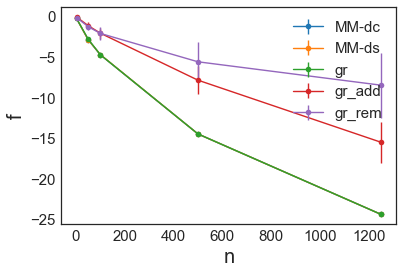

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
pal = sns.color_palette()
for c, al in zip(pal, sorted(set(df['algorithm']))):
#     if al != 'gr_rem':
#         continue
    df_ = df[df['algorithm'] == al]
    means = [np.mean(df_[df_['n'] == n]['obj']) for n in ns]
    stds = [np.std(df_[df_['n'] == n]['obj']) for n in ns]
    maxes = [np.max(df_[df_['n'] == n]['obj']) for n in ns]
    mins = [np.min(df_[df_['n'] == n]['obj']) for n in ns]
#     _ = ax.plot(ns, mins, color=c)
    _ = ax.errorbar(ns, means, yerr=stds / np.sqrt(len(starts)), fmt='-o', label=al, capsize=30, color=c)
#     _ = ax.fill_between(ns, maxes, mins, color=c, alpha=0.3)
_ = ax.set_xlabel('n')
_ = ax.set_ylabel('f')
_ = ax.legend()

In [16]:
results = {
    'df':df,
    'ds_list': ds_list,
    'dc_list': dc_list
}

with open('../outputs/20181003_phoq3_opt.pkl', 'wb') as f:
    pickle.dump(results, f)

In [24]:
df.tail()

,n,start,L,algorithm,obj
0,1250,"[(A, 0), (R, 0), (N, 0), (D, 0), (C, 0), (Q, 0...",4,gr_rem,tensor(-35.9310)
0,1250,"[(N, 2), (E, 2), (E, 1), (D, 2), (W, 0), (P, 2...",4,gr_rem,tensor(-0.5651)
0,1250,"[(I, 1), (D, 2), (W, 2), (M, 0), (C, 0), (D, 3...",4,gr_rem,tensor(-9.1217)
0,1250,"[(F, 1), (W, 2), (N, 0), (E, 1), (D, 1), (C, 2...",4,gr_rem,tensor(-14.1985)
0,2,"[(A, 0), (Q, 1), (S, 2), (V, 3)]",4,SS-dc,tensor(-0.2743)


In [25]:
df.head()

,n,start,L,algorithm,obj
0,2,"[(A, 0), (Q, 1), (S, 2), (V, 3)]",4,gr,tensor(-0.2743)
0,2,"[(A, 0), (R, 0), (N, 0), (D, 0), (C, 0), (Q, 0...",4,gr,tensor(-0.2696)
0,2,"[(N, 2), (E, 2), (E, 1), (D, 2), (W, 0), (P, 2...",4,gr,tensor(-0.2743)
0,2,"[(I, 1), (D, 2), (W, 2), (M, 0), (C, 0), (D, 3...",4,gr,tensor(-0.2696)
0,2,"[(F, 1), (W, 2), (N, 0), (E, 1), (D, 1), (C, 2...",4,gr,tensor(-0.2696)
